In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.utils.data as udata
import torch.optim as optim
import torch.nn.functional as F

# PyTorch geometric
import torch_geometric
import torch_geometric.data as geom_data
import torch_geometric.nn as geom_nn
from torch_geometric.nn import GCNConv
from torch_geometric.nn import DenseGCNConv
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import global_mean_pool

from torch_geometric.utils import to_networkx
import networkx as nx


#from sklearn.preprocessing import StandardScaler
from scipy.stats import norm

Total training events =  21914 838


/tmp/ipykernel_547/204687676.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train[column] = (y_train[column]-y_train[column].mean(axis=0))
/tmp/ipykernel_547/204687676.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test[column] = (y_test[column]-y_test[column].mean(axis=0))


'\nm_train = x_train.mean(0, keepdim=True)\ns_train = x_train.std(0, unbiased=False, keepdim=True)\nx_train -= m_train\nx_train /= 5*s_train\n\nm_train_y = y_train.mean(0, keepdim=True)\ns_train_y = y_train.std(0, unbiased=False, keepdim=True)\ny_train -= m_train_y\ny_train /= 5*s_train_y\n\nm_test = x_test.mean(0, keepdim=True)\ns_test = x_test.std(0, unbiased=False, keepdim=True)\nx_test -= m_test\nx_test /= 5*s_test\n\nm_test_y = y_test.mean(0, keepdim=True)\ns_test_y = y_test.std(0, unbiased=False, keepdim=True)\ny_test -= m_test_y\ny_test /= 5*s_test_y\n'

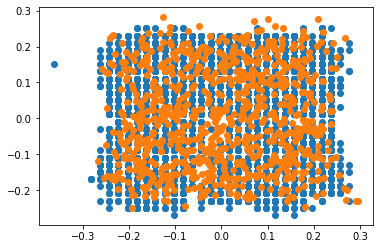

In [18]:
path = './'
#df_train = pd.read_csv('csv_TB3_Run21_croci450um_W3_285V_150kWfm.csv', sep=',')
df_train = pd.read_csv('/eos/user/f/fsiviero/RSD/pytorch/RSD-ML/csv_croci450-RSD2_Run111_285V_49.3pc_W3.csv', sep=',')
#df_test = pd.read_csv('csv_TB3_Run20_croci450um_W3_285V_40kWfm.csv', sep=',')
df_test = pd.read_csv('/eos/user/f/fsiviero/RSD/pytorch/RSD-ML/csv_TB3_Run20_croci450um_W3_285V_40kWfm.csv', sep=',')

df_train = df_train.dropna(axis=1)
df_test = df_test.dropna(axis=1)
df_train = df_train.dropna(axis=0)
df_test = df_test.dropna(axis=0)

#df_train = df_train.astype(double)
#df_test = df_test.astype(double)

Train = df_train
Test = df_test

x_low = -5.475
x_up = -4.575
y_low = -1.232
y_up = -0.332


train = Train[ (Train['x_tracker']>(x_low) ) & (Train['x_tracker']<(x_up)) \
              & (Train['y_tracker']>(y_low)) & (Train['y_tracker']<(y_up)) ]

test = Test[ (Test['x_tracker']>x_low) & (Test['x_tracker']<x_up) & (Test['y_tracker']>y_low) \
              & (Test['y_tracker']<y_up) ]

#train['x_tracker'] += -0.05
#train['y_tracker'] += 0.05

train = train[ (train['pmax6']>train['pmax1']) & (train['pmax6']>train['pmax2']) & (train['pmax6']>train['pmax3']) \
        & (train['pmax6']>train['pmax4']) & (train['pmax6']>train['pmax5']) & (train['pmax6']>train['pmax7']) \
        & (train['pmax6']>train['pmax8']) & (train['pmax6']>train['pmax9']) & (train['pmax6']>train['pmax11']) \
        & (train['pmax6']>train['pmax12']) & (train['pmax6']>train['pmax13']) & (train['pmax6']>train['pmax14']) ]

test = test[ (test['pmax6']>test['pmax1']) & (test['pmax6']>test['pmax2']) & (test['pmax6']>test['pmax3']) \
        & (test['pmax6']>test['pmax4']) & (test['pmax6']>test['pmax5']) & (test['pmax6']>test['pmax7']) \
        & (test['pmax6']>test['pmax8']) & (test['pmax6']>test['pmax9']) & (test['pmax6']>test['pmax11']) \
        & (test['pmax6']>test['pmax12']) & (test['pmax6']>test['pmax13']) & (test['pmax6']>test['pmax14']) ]

train = train[ (train['pmax6']>=10) ]
test = test[ (test['pmax6']>=5) ]
train = train[ (train['pmax6']<=40) ]
test = test[ (test['pmax6']<=40) ]
train = train[ (train['negpmax6']>=-15) ]
test = test[ (test['negpmax6']>=-15) ]
train = train[ (train['negpmax3']>=-15) & (train['negpmax4']>=-15) & (train['negpmax5']>=-15) & (train['negpmax7']>=-15) & (train['negpmax8']>=-15) & (train['negpmax9']>=-15) \
             & (train['negpmax11']>=-15) & (train['negpmax14']>=-15) ]
test = test[ (test['negpmax3']>=-15) & (test['negpmax4']>=-15) & (test['negpmax5']>=-15) & (test['negpmax7']>=-15) & (test['negpmax8']>=-15) & (test['negpmax9']>=-15) \
             & (test['negpmax11']>=-15) & (test['negpmax14']>=-15) ]

#plt.yscale("log")
#plt.hist(train['negpmax14'])
#plt.hist(test['negpmax14'])

y_train = train.iloc[:,:2]
x_train = train.drop(['x_tracker','y_tracker','x_rsd','y_rsd','t','t_reco','pmax0','negpmax0','tmax0'],axis=1)
x_train = x_train.drop(['pmax1','pmax2','pmax12','pmax13','negpmax1','negpmax2','negpmax12','negpmax13'],axis=1)
x_train = x_train.iloc[:,:18]
#x_train = x_train.iloc[:,:26]
#x_train['diff3'] = x_train['pmax3']+x_train['negpmax3']

y_test = test.iloc[:,:2]
x_test = test.drop(['x_tracker','y_tracker','x_rsd','y_rsd','t','t_reco','pmax0','negpmax0','tmax0'],axis=1)
x_test = x_test.drop(['pmax1','pmax2','pmax12','pmax13','negpmax1','negpmax2','negpmax12','negpmax13'],axis=1)
x_test = x_test.iloc[:,:18]
#x_test = x_test.iloc[:,:26]
#x_test['diff3'] = x_test['pmax3']+x_test['negpmax3']

n_var     = len(x_test.columns)
n_outputs = len(y_test.columns)
#print(x_test.columns, n_var)
#print(y_test.columns, n_outputs)

for column in x_train.columns:
    x_train[column] = (x_train[column]-x_train[column].mean(axis=0)) / x_train[column].abs().max()
    x_test[column] = (x_test[column]-x_test[column].mean(axis=0)) / x_test[column].abs().max()
    
#for column in x_train.columns:
    #print(x_train[column].min())
    #print(x_test[column].min())
    #print("\n")
    
for column in y_train.columns:
    y_train[column] = (y_train[column]-y_train[column].mean(axis=0))
    #/ y_train[column].abs().max()
    y_test[column] = (y_test[column]-y_test[column].mean(axis=0))
    # / y_test[column].abs().max()

y_cut = y_test
y_test = y_test[ (y_cut['x_tracker']>-0.3) & (y_cut['x_tracker']<0.3) & (y_cut['y_tracker']>-0.3) & (y_cut['y_tracker']<0.3) ]
x_test = x_test[ (y_cut['x_tracker']>-0.3) & (y_cut['x_tracker']<0.3) & (y_cut['y_tracker']>-0.3) & (y_cut['y_tracker']<0.3) ]

print("Total training events = ", len(y_train), len(y_test))

#plt.figure(figsize=(10,10))
plt.scatter(y_train.iloc[:,0],y_train.iloc[:,1])
plt.scatter(y_test.iloc[:,0],y_test.iloc[:,1])
#plt.yscale("log")
#plt.hist(x_train.iloc[:,1])
#plt.hist(x_test.iloc[:,1])
       
#display(x_train)

y_train = torch.tensor(y_train.values)
x_train = torch.tensor(x_train.values)

y_test = torch.tensor(y_test.values)
x_test = torch.tensor(x_test.values)


'''
m_train = x_train.mean(0, keepdim=True)
s_train = x_train.std(0, unbiased=False, keepdim=True)
x_train -= m_train
x_train /= 5*s_train

m_train_y = y_train.mean(0, keepdim=True)
s_train_y = y_train.std(0, unbiased=False, keepdim=True)
y_train -= m_train_y
y_train /= 5*s_train_y

m_test = x_test.mean(0, keepdim=True)
s_test = x_test.std(0, unbiased=False, keepdim=True)
x_test -= m_test
x_test /= 5*s_test

m_test_y = y_test.mean(0, keepdim=True)
s_test_y = y_test.std(0, unbiased=False, keepdim=True)
y_test -= m_test_y
y_test /= 5*s_test_y
'''

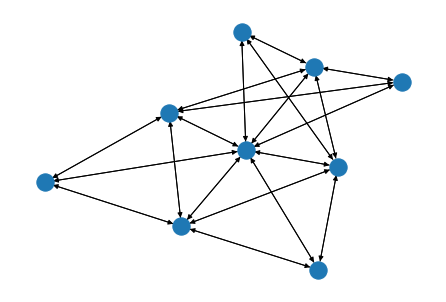

In [35]:
rms_noise = 0.5
data_list_train = []

for a, b in zip(x_train,y_train):
    feature_list =  [kx.item() for kx in a]
    node_train = torch.tensor([[feature_list[3],feature_list[12]],[feature_list[0],feature_list[9]],[feature_list[1],feature_list[10]],\
                      [feature_list[2],feature_list[11]],[feature_list[4],feature_list[13]],[feature_list[5],feature_list[14]],\
                      [feature_list[6],feature_list[15]],[feature_list[7],feature_list[16]],[feature_list[8],feature_list[17]]])
    
    edge_index = torch.tensor([[0,1],[1,0],[0,2],[2,0],[0,3],[3,0],[0,4],[4,0],[0,5],[5,0],[0,6],[6,0],[0,7],[7,0],[8,0],[0,8],\
                              [6,5],[5,6],[6,7],[7,6],[5,7],[7,5],[7,8],[8,7],[1,8],[8,1],[1,7],[7,1],[1,2],[2,1],[1,3],[3,1],[2,3],[3,2],[3,4],[4,3],[3,5],[5,3],[4,5],[5,4]])
    
    edge_weight = torch.tensor([[(feature_list[3]+feature_list[0]-2*rms_noise)/(feature_list[3]+feature_list[0])*min(feature_list[3],feature_list[0])/max(feature_list[3],feature_list[0])],[(feature_list[3]+feature_list[0]-2*rms_noise)/(feature_list[3]+feature_list[0])*min(feature_list[3],feature_list[0])/max(feature_list[3],feature_list[0])],\
                              [(feature_list[3]+feature_list[1]-2*rms_noise)/(feature_list[3]+feature_list[1])*min(feature_list[3],feature_list[1])/max(feature_list[3],feature_list[1])],[(feature_list[3]+feature_list[1]-2*rms_noise)/(feature_list[3]+feature_list[1])*min(feature_list[3],feature_list[1])/max(feature_list[3],feature_list[1])],\
                              [(feature_list[3]+feature_list[2]-2*rms_noise)/(feature_list[3]+feature_list[2])*min(feature_list[3],feature_list[2])/max(feature_list[3],feature_list[2])],[(feature_list[3]+feature_list[2]-2*rms_noise)/(feature_list[3]+feature_list[2])*min(feature_list[3],feature_list[2])/max(feature_list[3],feature_list[2])],\
                              [(feature_list[3]+feature_list[4]-2*rms_noise)/(feature_list[3]+feature_list[4])*min(feature_list[3],feature_list[4])/max(feature_list[3],feature_list[4])],[(feature_list[3]+feature_list[4]-2*rms_noise)/(feature_list[3]+feature_list[4])*min(feature_list[3],feature_list[4])/max(feature_list[3],feature_list[4])],\
                              [(feature_list[3]+feature_list[5]-2*rms_noise)/(feature_list[3]+feature_list[5])*min(feature_list[3],feature_list[5])/max(feature_list[3],feature_list[5])],[(feature_list[3]+feature_list[5]-2*rms_noise)/(feature_list[3]+feature_list[5])*min(feature_list[3],feature_list[5])/max(feature_list[3],feature_list[5])],\
                              [(feature_list[3]+feature_list[6]-2*rms_noise)/(feature_list[3]+feature_list[6])*min(feature_list[3],feature_list[6])/max(feature_list[3],feature_list[6])],[(feature_list[3]+feature_list[6]-2*rms_noise)/(feature_list[3]+feature_list[6])*min(feature_list[3],feature_list[6])/max(feature_list[3],feature_list[6])],\
                              [(feature_list[3]+feature_list[7]-2*rms_noise)/(feature_list[3]+feature_list[7])*min(feature_list[3],feature_list[7])/max(feature_list[3],feature_list[7])],[(feature_list[3]+feature_list[7]-2*rms_noise)/(feature_list[3]+feature_list[7])*min(feature_list[3],feature_list[7])/max(feature_list[3],feature_list[7])],\
                              [(feature_list[3]+feature_list[8]-2*rms_noise)/(feature_list[3]+feature_list[8])*min(feature_list[3],feature_list[8])/max(feature_list[3],feature_list[8])],[(feature_list[3]+feature_list[8]-2*rms_noise)/(feature_list[3]+feature_list[8])*min(feature_list[3],feature_list[8])/max(feature_list[3],feature_list[8])],\
                              [(feature_list[5]+feature_list[6]-2*rms_noise)/(feature_list[5]+feature_list[6])*min(feature_list[5],feature_list[6])/max(feature_list[5],feature_list[6])],[(feature_list[5]+feature_list[6]-2*rms_noise)/(feature_list[5]+feature_list[6])*min(feature_list[5],feature_list[6])/max(feature_list[5],feature_list[6])],\
                              [(feature_list[6]+feature_list[7]-2*rms_noise)/(feature_list[6]+feature_list[7])*min(feature_list[6],feature_list[7])/max(feature_list[6],feature_list[7])],[(feature_list[6]+feature_list[7]-2*rms_noise)/(feature_list[6]+feature_list[7])*min(feature_list[6],feature_list[7])/max(feature_list[6],feature_list[7])],\
                              [(feature_list[5]+feature_list[7]-2*rms_noise)/(feature_list[5]+feature_list[7])*min(feature_list[5],feature_list[7])/max(feature_list[5],feature_list[7])],[(feature_list[5]+feature_list[7]-2*rms_noise)/(feature_list[5]+feature_list[7])*min(feature_list[5],feature_list[7])/max(feature_list[5],feature_list[7])],\
                              [(feature_list[7]+feature_list[8]-2*rms_noise)/(feature_list[7]+feature_list[8])*min(feature_list[7],feature_list[8])/max(feature_list[7],feature_list[8])],[(feature_list[7]+feature_list[8]-2*rms_noise)/(feature_list[7]+feature_list[8])*min(feature_list[7],feature_list[8])/max(feature_list[7],feature_list[8])],\
                              [(feature_list[0]+feature_list[8]-2*rms_noise)/(feature_list[0]+feature_list[8])*min(feature_list[0],feature_list[8])/max(feature_list[0],feature_list[8])],[(feature_list[0]+feature_list[8]-2*rms_noise)/(feature_list[0]+feature_list[8])*min(feature_list[0],feature_list[8])/max(feature_list[0],feature_list[8])],\
                              [(feature_list[0]+feature_list[7]-2*rms_noise)/(feature_list[0]+feature_list[7])*min(feature_list[0],feature_list[7])/max(feature_list[0],feature_list[7])],[(feature_list[0]+feature_list[7]-2*rms_noise)/(feature_list[0]+feature_list[7])*min(feature_list[0],feature_list[7])/max(feature_list[0],feature_list[7])],\
                              [(feature_list[0]+feature_list[1]-2*rms_noise)/(feature_list[0]+feature_list[1])*min(feature_list[0],feature_list[1])/max(feature_list[0],feature_list[1])],[(feature_list[0]+feature_list[1]-2*rms_noise)/(feature_list[0]+feature_list[1])*min(feature_list[0],feature_list[1])/max(feature_list[0],feature_list[1])],\
                              [(feature_list[0]+feature_list[2]-2*rms_noise)/(feature_list[0]+feature_list[2])*min(feature_list[0],feature_list[2])/max(feature_list[0],feature_list[2])],[(feature_list[0]+feature_list[2]-2*rms_noise)/(feature_list[0]+feature_list[2])*min(feature_list[0],feature_list[2])/max(feature_list[0],feature_list[2])],\
                              [(feature_list[1]+feature_list[2]-2*rms_noise)/(feature_list[1]+feature_list[2])*min(feature_list[1],feature_list[2])/max(feature_list[1],feature_list[2])],[(feature_list[1]+feature_list[2]-2*rms_noise)/(feature_list[1]+feature_list[2])*min(feature_list[1],feature_list[2])/max(feature_list[1],feature_list[2])],\
                              [(feature_list[2]+feature_list[4]-2*rms_noise)/(feature_list[2]+feature_list[4])*min(feature_list[2],feature_list[4])/max(feature_list[2],feature_list[4])],[(feature_list[2]+feature_list[4]-2*rms_noise)/(feature_list[2]+feature_list[4])*min(feature_list[2],feature_list[4])/max(feature_list[2],feature_list[4])],\
                              [(feature_list[2]+feature_list[5]-2*rms_noise)/(feature_list[2]+feature_list[5])*min(feature_list[2],feature_list[5])/max(feature_list[2],feature_list[5])],[(feature_list[2]+feature_list[5]-2*rms_noise)/(feature_list[2]+feature_list[5])*min(feature_list[2],feature_list[5])/max(feature_list[2],feature_list[5])],\
                              [(feature_list[4]+feature_list[5]-2*rms_noise)/(feature_list[4]+feature_list[5])*min(feature_list[4],feature_list[5])/max(feature_list[4],feature_list[5])],[(feature_list[4]+feature_list[5]-2*rms_noise)/(feature_list[4]+feature_list[5])*min(feature_list[4],feature_list[5])/max(feature_list[4],feature_list[5])]])
    
    posit_list = [ky.item() for ky in b]
    y = torch.tensor([[posit_list[0],posit_list[1]]])
    edge_weight=edge_weight.abs()
    data_train = Data(x=node_train, edge_index=edge_index.t().contiguous(), edge_weight=edge_weight, y=y)
    #if(data_train.validate(raise_on_error=True)): 
    data_list_train.append(data_train)
      

loader_train = DataLoader(dataset=data_list_train, batch_size=1, num_workers=0, shuffle=True)

networkX_graph = to_networkx(data_train)
nx.draw(networkX_graph)

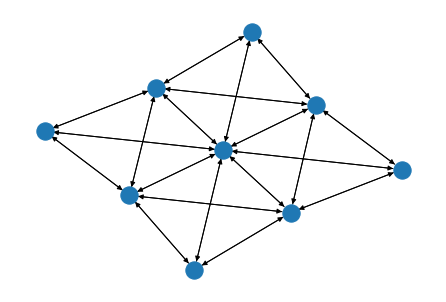

In [36]:
rms_noise = 0.5
data_list_test = []

for a, b in zip(x_test,y_test):
    feature_list =  [kx.item() for kx in a]
    node_test = torch.tensor([[feature_list[3],feature_list[12]],[feature_list[0],feature_list[9]],[feature_list[1],feature_list[10]],\
                      [feature_list[2],feature_list[11]],[feature_list[4],feature_list[13]],[feature_list[5],feature_list[14]],\
                      [feature_list[6],feature_list[15]],[feature_list[7],feature_list[16]],[feature_list[8],feature_list[17]]])
    
    edge_index = torch.tensor([[0,1],[1,0],[0,2],[2,0],[0,3],[3,0],[0,4],[4,0],[0,5],[5,0],[0,6],[6,0],[0,7],[7,0],[8,0],[0,8],\
                              [6,5],[5,6],[6,7],[7,6],[5,7],[7,5],[7,8],[8,7],[1,8],[8,1],[1,7],[7,1],[1,2],[2,1],[1,3],[3,1],[2,3],[3,2],[3,4],[4,3],[3,5],[5,3],[4,5],[5,4]])
    
    edge_weight = torch.tensor([[(feature_list[3]+feature_list[0]-2*rms_noise)/(feature_list[3]+feature_list[0])*min(feature_list[3],feature_list[0])/max(feature_list[3],feature_list[0])],[(feature_list[3]+feature_list[0]-2*rms_noise)/(feature_list[3]+feature_list[0])*min(feature_list[3],feature_list[0])/max(feature_list[3],feature_list[0])],\
                              [(feature_list[3]+feature_list[1]-2*rms_noise)/(feature_list[3]+feature_list[1])*min(feature_list[3],feature_list[1])/max(feature_list[3],feature_list[1])],[(feature_list[3]+feature_list[1]-2*rms_noise)/(feature_list[3]+feature_list[1])*min(feature_list[3],feature_list[1])/max(feature_list[3],feature_list[1])],\
                              [(feature_list[3]+feature_list[2]-2*rms_noise)/(feature_list[3]+feature_list[2])*min(feature_list[3],feature_list[2])/max(feature_list[3],feature_list[2])],[(feature_list[3]+feature_list[2]-2*rms_noise)/(feature_list[3]+feature_list[2])*min(feature_list[3],feature_list[2])/max(feature_list[3],feature_list[2])],\
                              [(feature_list[3]+feature_list[4]-2*rms_noise)/(feature_list[3]+feature_list[4])*min(feature_list[3],feature_list[4])/max(feature_list[3],feature_list[4])],[(feature_list[3]+feature_list[4]-2*rms_noise)/(feature_list[3]+feature_list[4])*min(feature_list[3],feature_list[4])/max(feature_list[3],feature_list[4])],\
                              [(feature_list[3]+feature_list[5]-2*rms_noise)/(feature_list[3]+feature_list[5])*min(feature_list[3],feature_list[5])/max(feature_list[3],feature_list[5])],[(feature_list[3]+feature_list[5]-2*rms_noise)/(feature_list[3]+feature_list[5])*min(feature_list[3],feature_list[5])/max(feature_list[3],feature_list[5])],\
                              [(feature_list[3]+feature_list[6]-2*rms_noise)/(feature_list[3]+feature_list[6])*min(feature_list[3],feature_list[6])/max(feature_list[3],feature_list[6])],[(feature_list[3]+feature_list[6]-2*rms_noise)/(feature_list[3]+feature_list[6])*min(feature_list[3],feature_list[6])/max(feature_list[3],feature_list[6])],\
                              [(feature_list[3]+feature_list[7]-2*rms_noise)/(feature_list[3]+feature_list[7])*min(feature_list[3],feature_list[7])/max(feature_list[3],feature_list[7])],[(feature_list[3]+feature_list[7]-2*rms_noise)/(feature_list[3]+feature_list[7])*min(feature_list[3],feature_list[7])/max(feature_list[3],feature_list[7])],\
                              [(feature_list[3]+feature_list[8]-2*rms_noise)/(feature_list[3]+feature_list[8])*min(feature_list[3],feature_list[8])/max(feature_list[3],feature_list[8])],[(feature_list[3]+feature_list[8]-2*rms_noise)/(feature_list[3]+feature_list[8])*min(feature_list[3],feature_list[8])/max(feature_list[3],feature_list[8])],\
                              [(feature_list[5]+feature_list[6]-2*rms_noise)/(feature_list[5]+feature_list[6])*min(feature_list[5],feature_list[6])/max(feature_list[5],feature_list[6])],[(feature_list[5]+feature_list[6]-2*rms_noise)/(feature_list[5]+feature_list[6])*min(feature_list[5],feature_list[6])/max(feature_list[5],feature_list[6])],\
                              [(feature_list[6]+feature_list[7]-2*rms_noise)/(feature_list[6]+feature_list[7])*min(feature_list[6],feature_list[7])/max(feature_list[6],feature_list[7])],[(feature_list[6]+feature_list[7]-2*rms_noise)/(feature_list[6]+feature_list[7])*min(feature_list[6],feature_list[7])/max(feature_list[6],feature_list[7])],\
                              [(feature_list[5]+feature_list[7]-2*rms_noise)/(feature_list[5]+feature_list[7])*min(feature_list[5],feature_list[7])/max(feature_list[5],feature_list[7])],[(feature_list[5]+feature_list[7]-2*rms_noise)/(feature_list[5]+feature_list[7])*min(feature_list[5],feature_list[7])/max(feature_list[5],feature_list[7])],\
                              [(feature_list[7]+feature_list[8]-2*rms_noise)/(feature_list[7]+feature_list[8])*min(feature_list[7],feature_list[8])/max(feature_list[7],feature_list[8])],[(feature_list[7]+feature_list[8]-2*rms_noise)/(feature_list[7]+feature_list[8])*min(feature_list[7],feature_list[8])/max(feature_list[7],feature_list[8])],\
                              [(feature_list[0]+feature_list[8]-2*rms_noise)/(feature_list[0]+feature_list[8])*min(feature_list[0],feature_list[8])/max(feature_list[0],feature_list[8])],[(feature_list[0]+feature_list[8]-2*rms_noise)/(feature_list[0]+feature_list[8])*min(feature_list[0],feature_list[8])/max(feature_list[0],feature_list[8])],\
                              [(feature_list[0]+feature_list[7]-2*rms_noise)/(feature_list[0]+feature_list[7])*min(feature_list[0],feature_list[7])/max(feature_list[0],feature_list[7])],[(feature_list[0]+feature_list[7]-2*rms_noise)/(feature_list[0]+feature_list[7])*min(feature_list[0],feature_list[7])/max(feature_list[0],feature_list[7])],\
                              [(feature_list[0]+feature_list[1]-2*rms_noise)/(feature_list[0]+feature_list[1])*min(feature_list[0],feature_list[1])/max(feature_list[0],feature_list[1])],[(feature_list[0]+feature_list[1]-2*rms_noise)/(feature_list[0]+feature_list[1])*min(feature_list[0],feature_list[1])/max(feature_list[0],feature_list[1])],\
                              [(feature_list[0]+feature_list[2]-2*rms_noise)/(feature_list[0]+feature_list[2])*min(feature_list[0],feature_list[2])/max(feature_list[0],feature_list[2])],[(feature_list[0]+feature_list[2]-2*rms_noise)/(feature_list[0]+feature_list[2])*min(feature_list[0],feature_list[2])/max(feature_list[0],feature_list[2])],\
                              [(feature_list[1]+feature_list[2]-2*rms_noise)/(feature_list[1]+feature_list[2])*min(feature_list[1],feature_list[2])/max(feature_list[1],feature_list[2])],[(feature_list[1]+feature_list[2]-2*rms_noise)/(feature_list[1]+feature_list[2])*min(feature_list[1],feature_list[2])/max(feature_list[1],feature_list[2])],\
                              [(feature_list[2]+feature_list[4]-2*rms_noise)/(feature_list[2]+feature_list[4])*min(feature_list[2],feature_list[4])/max(feature_list[2],feature_list[4])],[(feature_list[2]+feature_list[4]-2*rms_noise)/(feature_list[2]+feature_list[4])*min(feature_list[2],feature_list[4])/max(feature_list[2],feature_list[4])],\
                              [(feature_list[2]+feature_list[5]-2*rms_noise)/(feature_list[2]+feature_list[5])*min(feature_list[2],feature_list[5])/max(feature_list[2],feature_list[5])],[(feature_list[2]+feature_list[5]-2*rms_noise)/(feature_list[2]+feature_list[5])*min(feature_list[2],feature_list[5])/max(feature_list[2],feature_list[5])],\
                              [(feature_list[4]+feature_list[5]-2*rms_noise)/(feature_list[4]+feature_list[5])*min(feature_list[4],feature_list[5])/max(feature_list[4],feature_list[5])],[(feature_list[4]+feature_list[5]-2*rms_noise)/(feature_list[4]+feature_list[5])*min(feature_list[4],feature_list[5])/max(feature_list[4],feature_list[5])]])
      
    posit_list = [ky.item() for ky in b]
    y = torch.tensor([[posit_list[0],posit_list[1]]])
    edge_weight=edge_weight.abs()
    data_test = Data(x=node_test, edge_index=edge_index.t().contiguous(), edge_weight=edge_weight, y=y)
    #if(data_test.validate(raise_on_error=True)): 
    data_list_test.append(data_test)

loader_test = DataLoader(dataset=data_list_test, batch_size=1, num_workers=0, shuffle=False)
networkX_graph = to_networkx(data_test)
nx.draw(networkX_graph)

In [37]:
epochs        = 30
n_nodes       = 256
n_outputs     = 2
n_var         = 2
drop_out_p    = 0.2
learning_rate = 0.0000001
#learning_rate = 0.01
verbose       = True

In [38]:
# Define GNN model
class GNN(torch.nn.Module):
    def __init__(self, n_var, n_nodes, n_outputs, drop_out_p):
        super(GNN, self).__init__()
        torch.manual_seed(1234)
        self.conv1 = GCNConv(n_var, n_nodes)
        self.conv2 = GCNConv(n_nodes, n_nodes)
        self.conv3 = GCNConv(n_nodes, n_nodes)
        self.lin1 = nn.Linear(n_nodes, n_nodes)
        self.lin2 = nn.Linear(n_nodes, n_nodes)
        self.lin3 = nn.Linear(n_nodes, n_outputs)
        
        
    def forward(self, x, edge_index, edge_weight):
    #def forward(self, x, edge_index):
        xx = self.conv1(x, edge_index, edge_weight)
        #xx = self.conv1(x, edge_index)
        xx = xx.tanh()
        xx = F.dropout(xx, p=drop_out_p)
        #xx = self.conv2(xx, edge_index, edge_weight)  
        #xx = xx.tanh()
        xx = self.conv3(xx, edge_index, edge_weight)
        #xx = self.conv3(xx, edge_index)
        xx = xx.tanh()
        #xx = F.dropout(xx, p=drop_out_p)
        xx = self.lin1(xx)
        xx = xx.tanh()
        #xx = F.dropout(xx, p=drop_out_p)
        xx = self.lin2(xx)
        xx = xx.tanh()
        xx = self.lin3(xx)
        return xx
        
        #xx = F.dropout(x, p=drop_out_p, training=self.training)
        #xx = global_mean_pool(xx)
        #x = nn.BatchNorm1d(n_nodes)
        #xx = xx.relu()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GNN(n_var=n_var, n_nodes=n_nodes, n_outputs=n_outputs, drop_out_p=drop_out_p).to(device)

# Loss function
criterion = nn.MSELoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr = learning_rate, weight_decay=1e-3)

scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.5, last_epoch=-1, verbose=verbose)

Adjusting learning rate of group 0 to 1.0000e-07.


In [39]:
training_losses_total = np.zeros(epochs)
validation_losses_total = np.zeros(epochs)

diff_x_train = []
diff_y_train = []
xxx_o_train = []
yyy_o_train = []
xxx_train = []
yyy_train = []

diff_x_test = []
diff_y_test = []
xxx_o_test = []
yyy_o_test = []
xxx_test = []
yyy_test = []

# training and validation
for epoch in range(epochs):
    if verbose: print("Beginning epoch " + str(epoch))
    # training
    train_loss_total = 0
    for i, data in enumerate(loader_train,0):
        model.float()
        model.train()
        model.zero_grad()
        optimizer.zero_grad()
        output = model(data.x, data.edge_index, data.edge_weight)
        #output = model(data.x, data.edge_index)
        batch_loss_total = criterion(data.y[0], output[0])        
        batch_loss_total.backward()
        optimizer.step()
        model.eval()
        if epoch==(epochs-1):
            diff_x_train.append(data.y[0][0].detach().numpy()-output[0][0].detach().numpy())
            diff_y_train.append(data.y[0][1].detach().numpy()-output[0][1].detach().numpy())
            xxx_o_train.append(data.y[0][0].detach().numpy())
            yyy_o_train.append(data.y[0][1].detach().numpy())
            xxx_train.append(output[0][0].detach().numpy())
            yyy_train.append(output[0][1].detach().numpy())
        train_loss_total += batch_loss_total.item()
    train_loss_total /= len(loader_train)
    training_losses_total[epoch] = train_loss_total
    if np.isnan(train_loss_total):
        print("nan in training")
        break
    if verbose: print("t_total: "+ str(train_loss_total))
        
    # validation
    val_loss_total = 0
    for i, data in enumerate(loader_test):
        output = model(data.x, data.edge_index, data.edge_weight)
        #output = model(data.x, data.edge_index)
        batch_loss_total = criterion(data.y[0], output[0]) 
        if epoch==(epochs-1):
            diff_x_test.append(data.y[0][0].detach().numpy()-output[0][0].detach().numpy())
            diff_y_test.append(data.y[0][1].detach().numpy()-output[0][1].detach().numpy())
            xxx_o_test.append(data.y[0][0].detach().numpy())
            yyy_o_test.append(data.y[0][1].detach().numpy())
            xxx_test.append(output[0][0].detach().numpy())
            yyy_test.append(output[0][1].detach().numpy())
        val_loss_total += batch_loss_total.item()
    val_loss_total /= len(loader_test)
    #scheduler.step()
    validation_losses_total[epoch] = val_loss_total
    if np.isnan(val_loss_total):
        print("nan in val")
        break
    if verbose: print("v_total: "+ str(val_loss_total))
    
    # save the model
    model.eval()
    #modelLocation = "{}/net_{}.pth".format(".",epoch)
    #torch.save(model.state_dict(), modelLocation)
    
print("Finished")
print("Final loss train:", training_losses_total[-1])
print("Final loss test:",  validation_losses_total[-1])

Beginning epoch 0


KeyboardInterrupt: 

In [ ]:
# plot loss/epoch for training and validation sets
print("Making basic validation plots")
training_total = plt.plot(training_losses_total, label='training_total')
validation_total = plt.plot(validation_losses_total, label='validation_total')
#plt.yscale("log")
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()
#plt.savefig("loss_plot.png")

In [ ]:
plt.hist(diff_x_train,100)
plt.hist(diff_y_train,100)
plt.show()

In [ ]:
plt.hist(diff_x_test,100)
plt.hist(diff_y_test,100)
plt.show()

In [ ]:
mu_x_train, sigma_x_train = norm.fit(diff_x_train)
mu_y_train, sigma_y_train = norm.fit(diff_y_train)
print('Sigma x-axis: '+str(sigma_x_train))
print('Sigma y-axis: '+str(sigma_y_train))

mu_x_test, sigma_x_test = norm.fit(diff_x_test)
mu_y_test, sigma_y_test = norm.fit(diff_y_test)
print('Sigma x-axis: '+str(sigma_x_test))
print('Sigma y-axis: '+str(sigma_y_test))

#np.savetxt('pippo.txt', diff, fmt='%f')

In [ ]:
plt.figure(figsize=(10,10))
plt.scatter(xxx_o_train,yyy_o_train)
plt.scatter(xxx_train,yyy_train)
#display(yyy_train)

In [ ]:
plt.figure(figsize=(10,10))
plt.scatter(xxx_o_test,yyy_o_test)
plt.scatter(xxx_test,yyy_test)
#display(xxx_test)